# Lowe Fall 2021 FG Data Automation Team Tech Challenge

Data:
1. Quarterly Total Nonfarm Employment (ID PAYEMS) from 2000 through 2020
2. Quarterly Real Gross Domestic Product (ID GDPC1) from 2000 through 2020
3. Quarterly Consumer Price Index (ID CPIAUCSL) from 2000 through 2020
and
4. Choose own: Share of Total Net Worth Held by the Top 1% (99th to 100th Wealth Percentiles) (WFRBST01134)
5. Choose own: Homeownership Rate in the United States (RHORUSQ156N)
    
Outcomes:
1. CSV from pandas data frame of combined given data
3. Time series with all 3 given data
4. Scatterplot with 2 of given data (against each other)
5. Histogram of one of the given data
6. Time series of two elective data

In [1]:
# For data fetching
from dotenv import load_dotenv, find_dotenv
import os
import requests

# For data process
from datetime import datetime
import pandas as pd

# For plotting
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
%matplotlib notebook

# numpy for arange, for the tick marks
import numpy as np

# For saving
project_dir = '/Users/aaronxie/Documents/CodingProjects/lowe_temp/interviews/'

## Fetch Data

get value and date
date is formatted as YYYY-MM-DD

to work with it:
create datetime object
then can plot from matplotlib.dates.date2num(d)

In [2]:
def fetch(id):
    '''
    Returns JSON response of data from FRED for given series ID
    '''
    # Get API Key from .env file
    path_to_dotenv = find_dotenv()
    load_dotenv(path_to_dotenv)
    apikey = os.environ.get("key", None)
    params = {'api_key': apikey, 'series_id':id,'file_type':'json'}
    rawRes = requests.get('https://api.stlouisfed.org/fred/series/observations', params=params)
    res = rawRes.json()
    return res

In [3]:
def parseDate(strDate):
    return datetime.strptime(strDate, "%Y-%m-%d").date()

In [4]:
def jsonToDf(org_dict, valueName):
    df = pd.DataFrame.from_dict(org_dict)
    df.drop(columns=['realtime_start', 'realtime_end'], inplace=True, axis=1)
    df['date'] = df['date'].map(parseDate)
    df['value'] = df['value'].astype("float")
    df.rename(columns={'value':valueName}, inplace=True)
    return df

In [5]:
json_employee = fetch('PAYEMS')['observations']
json_gdp = fetch('GDPC1')['observations']
json_cpi = fetch('CPIAUCSL')['observations']
json_1p = fetch('WFRBST01134')['observations']
json_home = fetch('RHORUSQ156N')['observations']
raw_df_employee = jsonToDf(json_employee, "Employment (Thousands of People)")
raw_df_gdp = jsonToDf(json_gdp, 'GDP (Billions of Dollars)')
raw_df_cpi = jsonToDf(json_cpi, 'CPI (1982-1984=100%)')
raw_df_1p = jsonToDf(json_1p, '% of Total Net Worth Held by the Top 1%')
raw_df_home = jsonToDf(json_home, 'Home ownership (Percent)')

## Process Data

In [6]:
def truncate(df):
    start_date = datetime(2000, 1, 1).date()
    end_date = datetime(2020, 12, 31).date()
    df = df[((df['date'] >= start_date) & (df['date'] <= end_date))]
    df.reset_index(drop=True, inplace=True)
    return df

In [7]:
df_employee = truncate(raw_df_employee)
df_gdp = truncate(raw_df_gdp)
df_cpi = truncate(raw_df_cpi)
df_1p = truncate(raw_df_1p)
df_home = truncate(raw_df_home)

In [8]:
df_main = df_employee.merge(df_gdp, on=['date', 'date'], how="outer")
df_main = df_main.merge(df_cpi, on=['date', 'date'], how="outer")
df_main = df_main.merge(df_1p, on=['date', 'date'], how="outer")
df_main = df_main.merge(df_home, on=['date', 'date'], how="outer")
df_main

,date,Employment (Thousands of People),GDP (Billions of Dollars),CPI (1982-1984=100%),% of Total Net Worth Held by the Top 1%,Home ownership (Percent)
0,2000-01-01,131005.0,12935.252,169.300,28.5,67.1
1,2000-02-01,131124.0,NaN,170.000,NaN,NaN
2,2000-03-01,131596.0,NaN,171.000,NaN,NaN
3,2000-04-01,131888.0,13170.749,170.900,28.1,67.2
4,2000-05-01,132105.0,NaN,171.200,NaN,NaN
...,...,...,...,...,...,...
247,2020-08-01,141149.0,NaN,259.511,NaN,NaN
248,2020-09-01,141865.0,NaN,260.149,NaN,NaN
249,2020-10-01,142545.0,18767.778,260.462,31.7,65.8
250,2020-11-01,142809.0,NaN,260.927,NaN,NaN


In [9]:
# This was causing huge issues; not having the right type, need to make sure the numbers are numbers
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   date                                     252 non-null    object 
 1   Employment (Thousands of People)         252 non-null    float64
 2   GDP (Billions of Dollars)                84 non-null     float64
 3   CPI (1982-1984=100%)                     252 non-null    float64
 4   % of Total Net Worth Held by the Top 1%  84 non-null     float64
 5   Home ownership (Percent)                 84 non-null     float64
dtypes: float64(5), object(1)
memory usage: 13.8+ KB


#### Outcome 1

In [10]:
df_temp = df_main.drop(['% of Total Net Worth Held by the Top 1%', 'Home ownership (Percent)'], axis=1)
df_temp.to_csv(project_dir+'ans.csv')

## Plot

In [11]:
def plot_timeseries(yData1Title, yData2Title, yData3Title=None):
    '''
    to plot time series data
    only generalized so far as to plot 2 or 3 of the data frames in df_main; this is all the DRY needed for the given tasks
    '''
    fig, ax = plt.subplots(figsize=(5.5,3))
    # Config for multiple y axis
    if yData3Title != None:
        fig.subplots_adjust(right=0.75)
    
    # First Set of Data
    df_1 = df_main[df_main[yData1Title].notna()] #trick for NaN data via https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan
    dataY1 = df_1[yData1Title]
    dataX1 = df_1['date']
    dataX1 = mdates.date2num(dataX1)
    
    plt1, = ax.plot(dataX1, dataY1, color="Orange", marker="*", label=yData1Title) # return plt1 for the legend
    ax.set_ylabel(yData1Title)
    
    # Config X axes
    ax.set_xticks(np.arange(min(dataX1), max(dataX1)+400, 850))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_xlabel('Date (Y-M)', labelpad=10.0)

    # Second Set of Data
    ax2 = ax.twinx()
    
    df_2 = df_main[df_main[yData2Title].notna()]
    dataY2 = df_2[yData2Title]
    dataX2 = df_2['date']
    dataX2 = mdates.date2num(dataX2)
    
    plt2, = ax2.plot(dataX2, dataY2, color="Red", marker="o", label=yData2Title)
    ax2.set_ylabel(yData2Title)
    
    # Optional: Third Set of data
    if yData3Title != None:
        ax3 = ax.twinx()
        ax3.spines.right.set_position(("axes", 1.15)) # config for overlapping third axes
        
        df_2 = df_main[df_main[yData3Title].notna()]
        dataY3 = df_2[yData3Title]
        dataX3 = df_2['date']
        dataX3 = mdates.date2num(dataX3)
        
        plt3, = ax3.plot(dataX3, dataY3, color="Blue", marker="+", label=yData3Title)
        ax3.set_ylabel(yData3Title)
        
        # Config Combined Legend
        ax.legend(handles=[plt1, plt2, plt3])
        plt.title(yData1Title + ' and ' + yData2Title + " and " + yData3Title)
        plt.tight_layout()
    else:
        # Config Combined Legend
        ax.legend(handles=[plt1, plt2])
        plt.title(yData1Title + ' and ' + yData2Title)
        plt.tight_layout()

#### Outcome 3

<IPython.core.display.Javascript object>


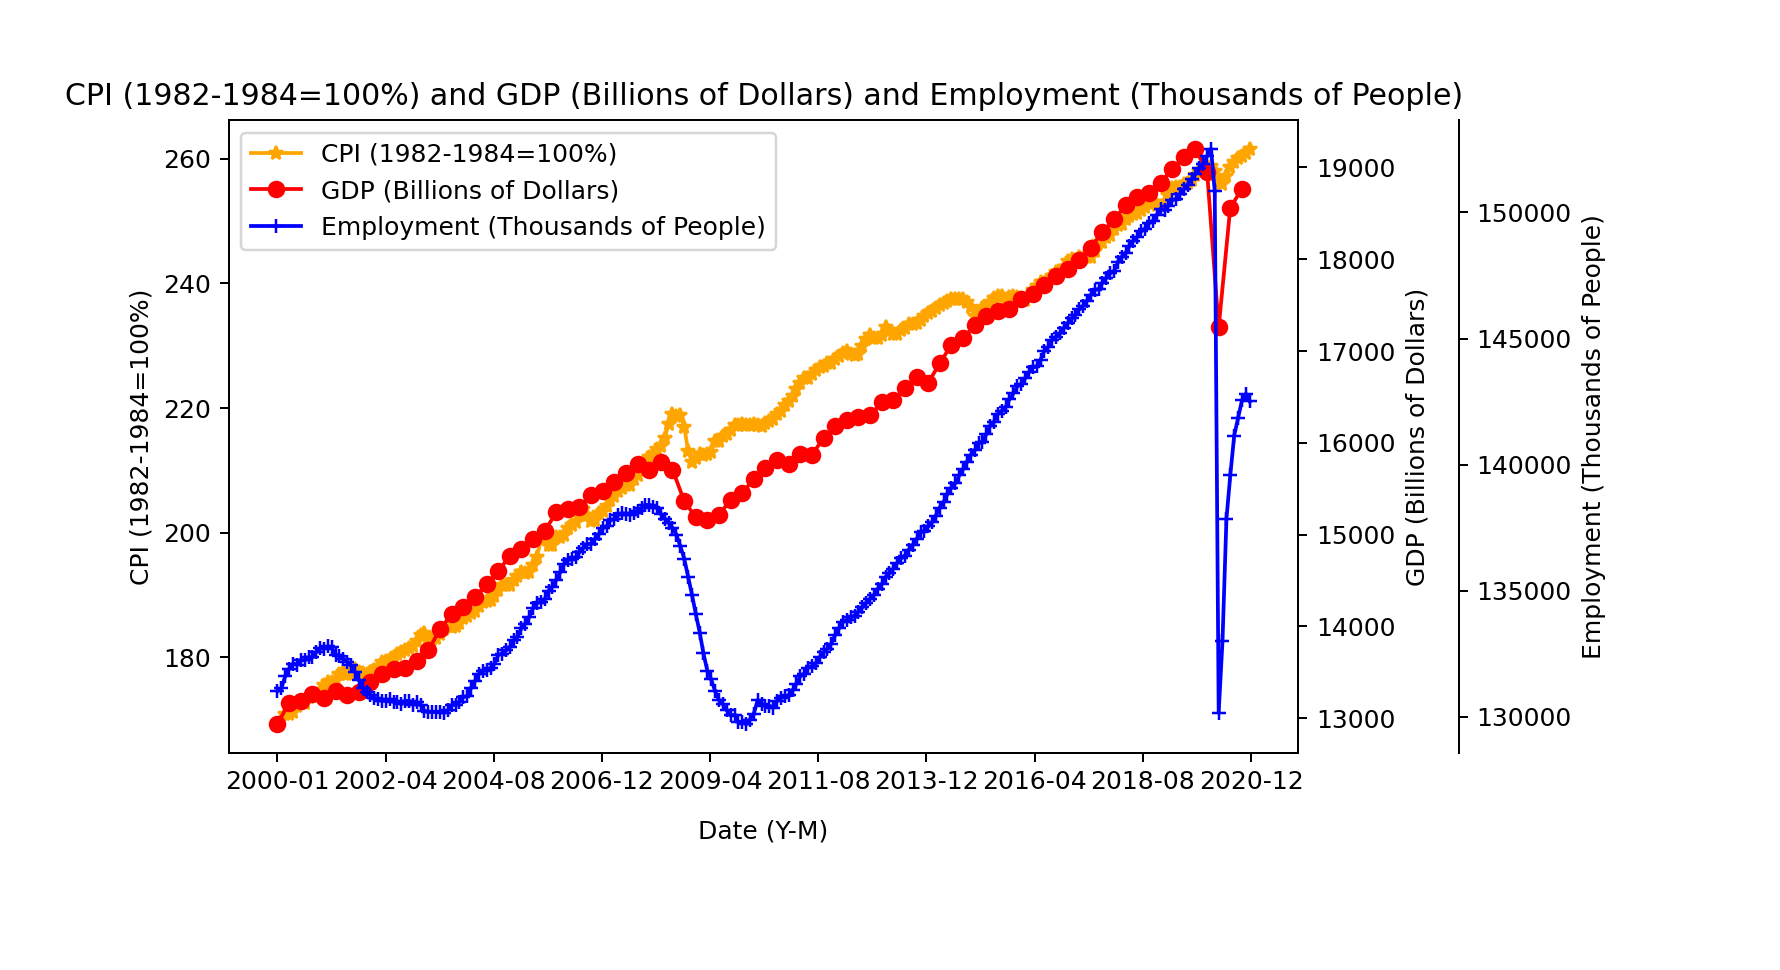

In [12]:
plot_timeseries('CPI (1982-1984=100%)', 'GDP (Billions of Dollars)', 'Employment (Thousands of People)')

#### Outcome 6

<IPython.core.display.Javascript object>


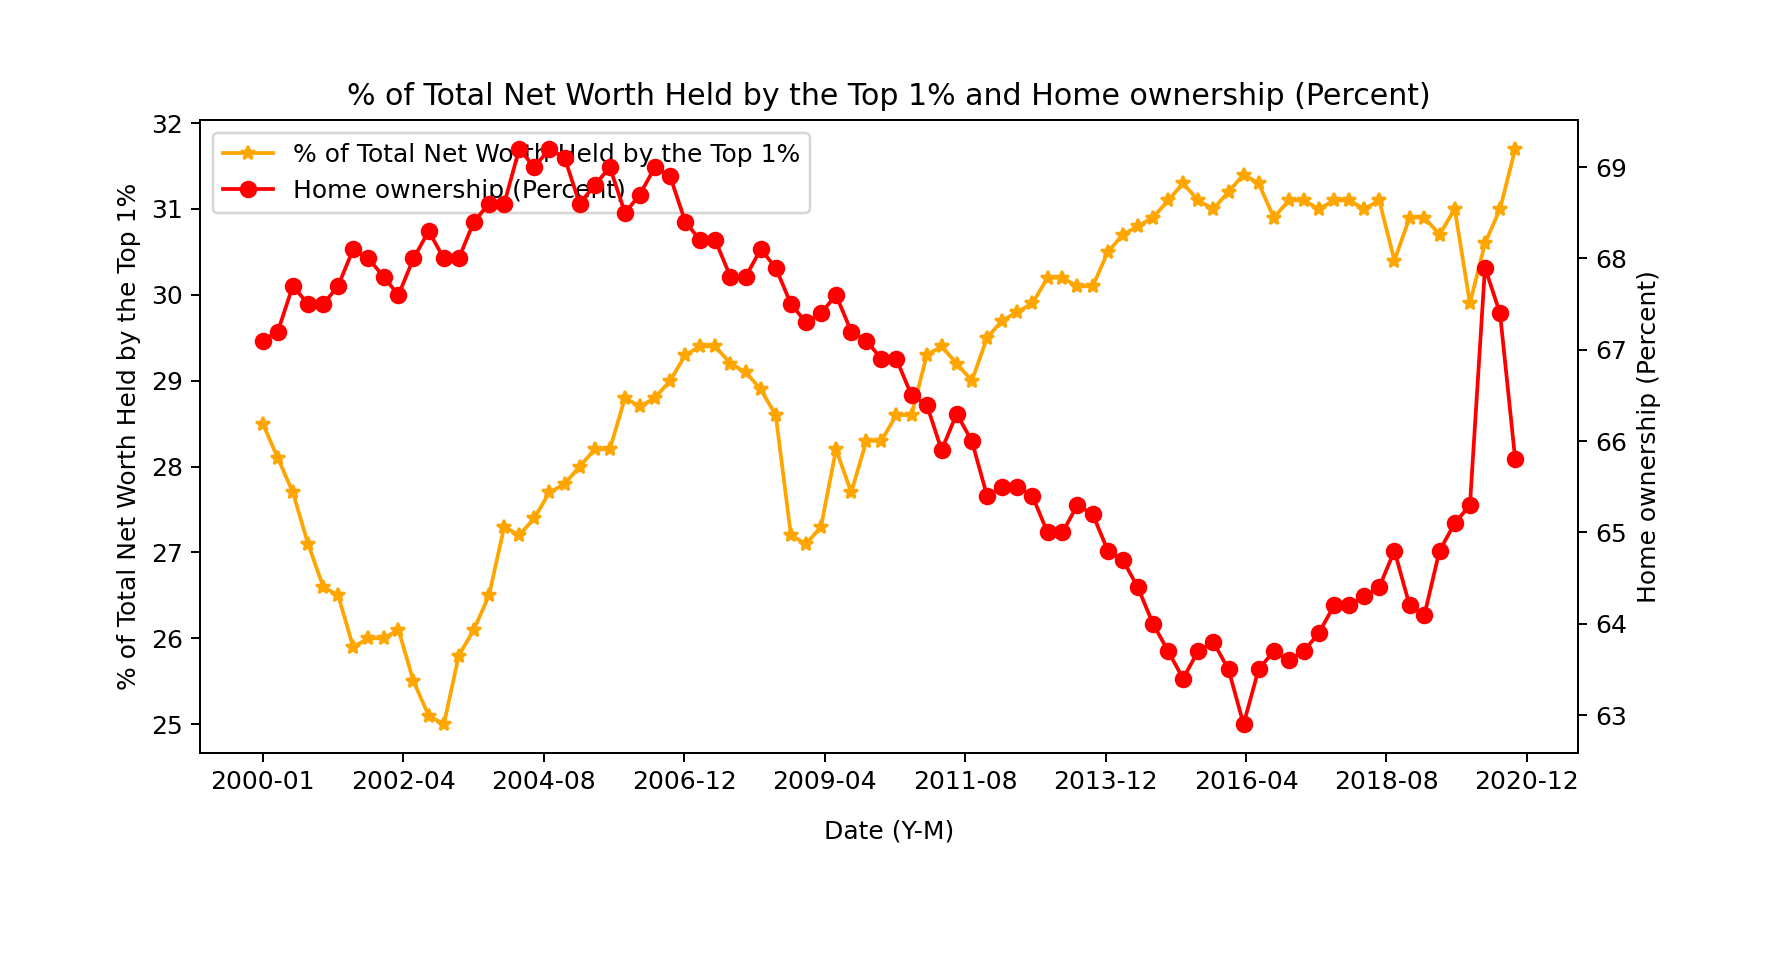

In [13]:
plot_timeseries('% of Total Net Worth Held by the Top 1%', 'Home ownership (Percent)')

In [14]:
def plot_hist(yDataTitle):
    fig, ax = plt.subplots(figsize=(5,3))
    dataY1 = df_main[yDataTitle]
    dataX = df_main['date']
    dataX = mdates.date2num(dataX)
    binwidth = 10
    bins=range(int(min(dataY1)/10)*10, int(max(dataY1)/10)*10 + binwidth, binwidth)
    ax.hist(dataY1, bins=bins)
    plt.xticks(bins)
    ax.set_xlabel(yDataTitle)
    ax.set_ylabel('Freq')
    plt.title(yDataTitle + ' during 2000-2020')
    plt.tight_layout()

#### Outcome 5

<IPython.core.display.Javascript object>


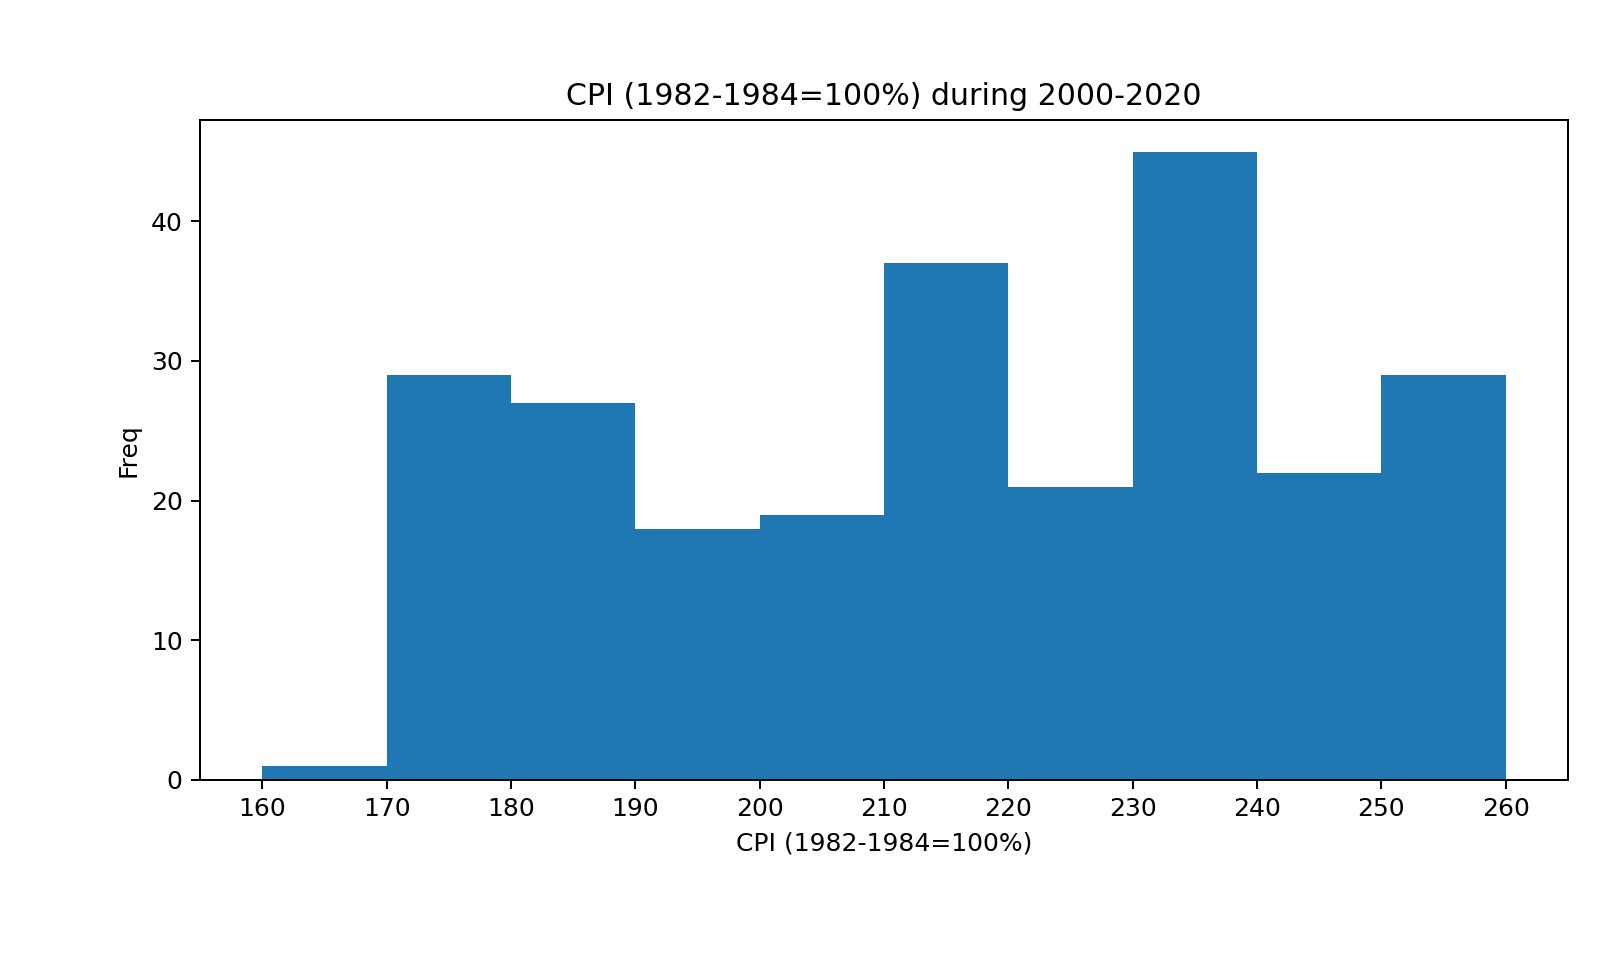

In [15]:
plot_hist('CPI (1982-1984=100%)')

In [16]:
def plot_scatter(data1Title, data2Title):
    fig, ax = plt.subplots(figsize=(5,3))
    data1 = df_main[data1Title]
    data2 = df_main[data2Title]
    ax.scatter(data1, data2)
    ax.set_xlabel(data1Title)
    ax.set_ylabel(data2Title)
    plt.title(data1Title + " vs " + data2Title)
    plt.tight_layout()

#### Outcome 4

<IPython.core.display.Javascript object>


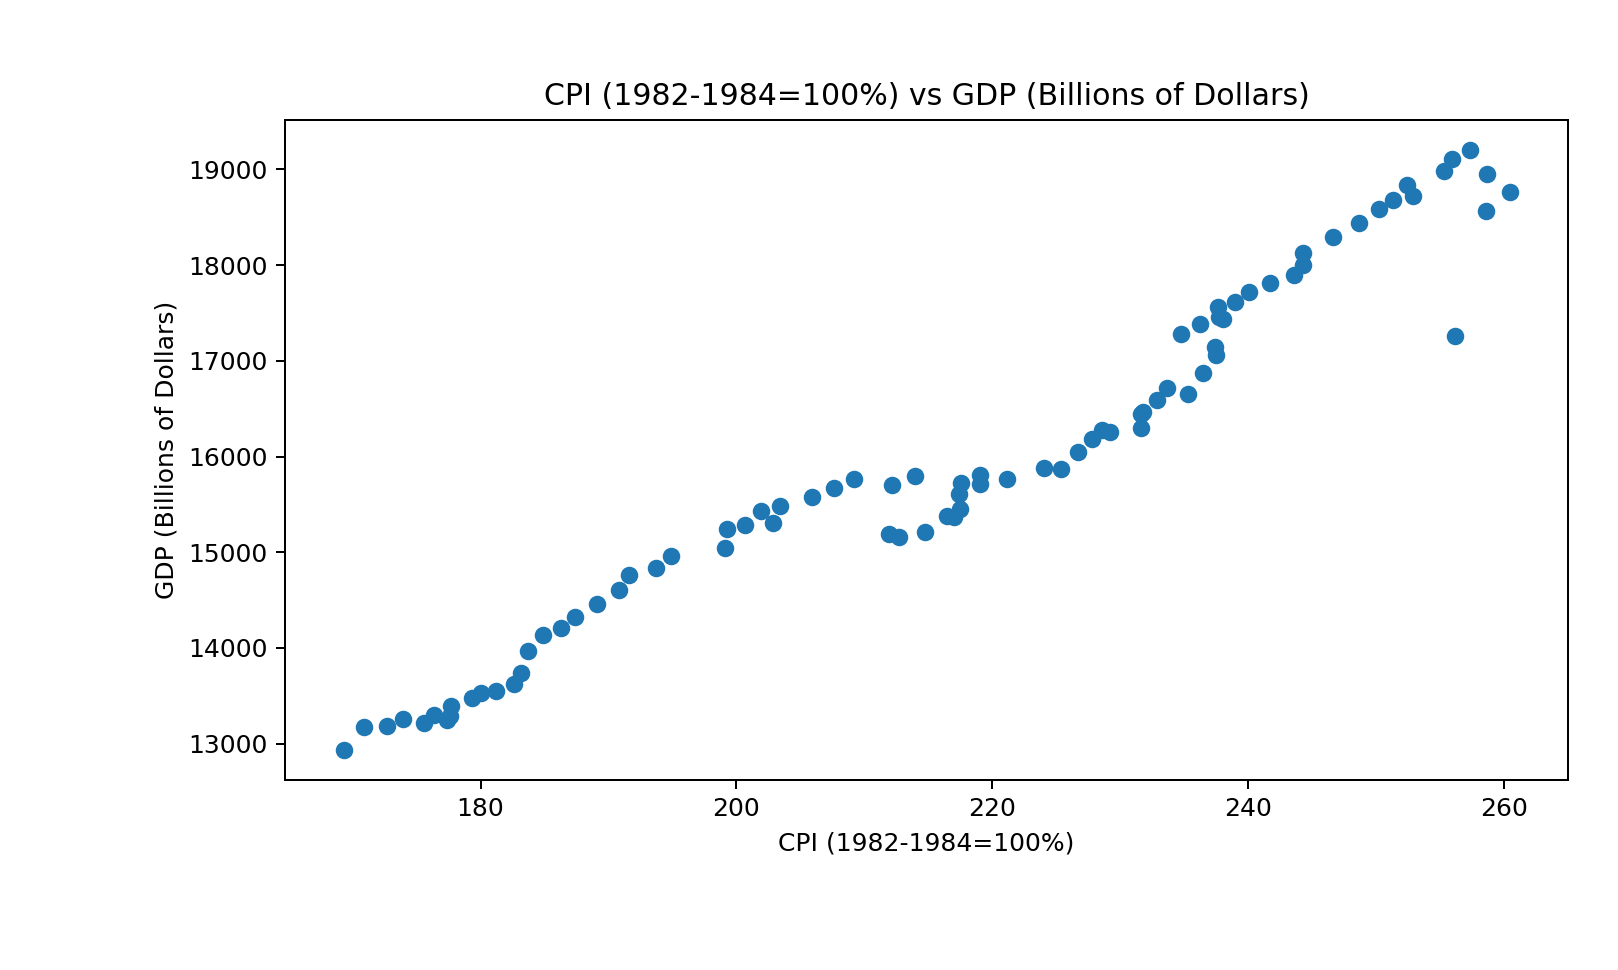

In [17]:
plot_scatter('CPI (1982-1984=100%)', 'GDP (Billions of Dollars)')